In [1]:
# %%
# =============================================================================
# 1. IMPORTS AND WARNINGS SETUP
#    - Load necessary PyTorch modules, utilities, and suppress UserWarnings
# =============================================================================
import torch
from utils import (generate_channels_and_labels, tokenizer_train, tokenizer, make_sample, nmse_loss,
                   create_train_dataloader, patch_maker, count_parameters, train_lwm)
from collections import defaultdict
import numpy as np
import pretrained_model  # Assuming this contains the LWM model definition
import matplotlib.pyplot as plt
import warnings
import os
import bisect
# from collections import defaultdict
from tqdm import tqdm
warnings.filterwarnings("ignore", category=UserWarning)
from utils import *
import deepmimo as dm
from sklearn.metrics import mean_squared_error
import numpy as np
    
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [2]:
scenario = 'city_0_newyork_3p5'
dm.download(scenario)
dataset = dm.load(scenario, )

Scenario "city_0_newyork_3p5" already exists in /home/johnny/bless/deepmimo_scenarios
Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


<Axes3D: title={'center': 'Buildings: 282, Terrain: 1'}, xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)'>

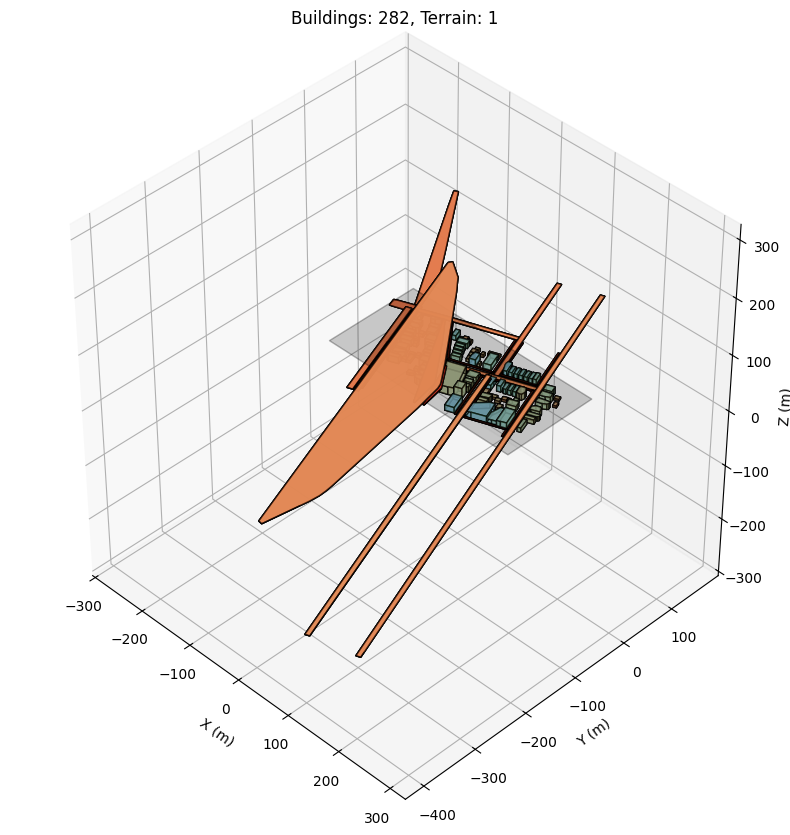

In [3]:
dataset.scene.plot()


In [4]:
data = dm.load(scenario, )  

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)


In [5]:
dm.info()


Fundamental Matrices:
power: Tap power. Received power in dBW for each path, assuming 0 dBW transmitted power. 
10*log10(|a|²), where a is the complex channel amplitude
	[num_rx, num_paths]
phase: Tap phase. Phase of received signal for each path in degrees. 
∠a (angle of a), where a is the complex channel amplitude
	[num_rx, num_paths]
delay: Tap delay. Propagation delay for each path in seconds
	[num_rx, num_paths]
aoa_az: Angle of arrival (azimuth) for each path in degrees
	[num_rx, num_paths]
aoa_el: Angle of arrival (elevation) for each path in degrees
	[num_rx, num_paths]
aod_az: Angle of departure (azimuth) for each path in degrees
	[num_rx, num_paths]
aod_el: Angle of departure (elevation) for each path in degrees
	[num_rx, num_paths]
inter: Type of interactions along each path
	Codes: 0: LOS, 1: Reflection, 2: Diffraction, 3: Scattering, 4: Transmission
	Code meaning: 121 -> Tx-R-D-R-Rx
	[num_rx, num_paths]
inter_pos: 3D coordinates in meters of each interaction point along p

In [6]:
data['num_paths'][0]






DeepMIMOArray([0, 0, 0, ..., 0, 0, 0], shape=(31719,))

In [7]:
data['rt_params']['raw_params']['studyarea']['boundary']['values']# .keys()

{'nVertices': 4,
 'reference': {'data': [],
 'kind': '',
 'labels': ['cartesian', 'terrain'],
 'name': '',
 'values': {'latitude': 0, 'longitude': 0, 'visible': False}},
 'zmax': 17.5,
 'zmin': -3.0}

In [8]:
config = {
    "BATCH_SIZE":32,
    "PAD_VALUE": 500,
    "USE_WANDB": False,
    "LR":1e-5,
    "epochs" : 100
}

In [9]:
class MySeqDataLoader(torch.utils.data.Dataset):

    def __init__(self, scenario, tx_sets = "all", seed=42, shuffle=False, pad_value = 500, train= True, split_by = "users", train_ratio = 0.8, sort_by="power"):
        ### get length of dataset
        # if tx_sets
        self.dataset = dm.load(scenario, tx_sets=tx_sets)
        self.Txs = 1
        self.pad_value = pad_value
        self.split_by = split_by
        self.sort_by = sort_by  # "power" or "delay"
        self.dataset_filtered = defaultdict(list)
        self.total_length = 0
        if type(self.dataset) == dict:
            self.dataset =  [self.dataset]
        
        if split_by == "Tx":
            self.Txs = list(range(len(self.dataset)) )
            if train:
                self.Txs = self.Txs[: int(train_ratio * len(self.Txs))]
                
            else:
                self.Txs = self.Txs = self.Txs[int(train_ratio * len(self.Txs)):]


            for tx in self.Txs:
                use_indices = dataset[tx].los != -1
                
                n_ue = dataset[tx].n_ue           
            
                for k in dataset[tx]:
                    if k not in ["txrx", "load_params", "name", "rt_params",     "materials", "scene", "n_ue"]:
                        if dataset[tx][k].shape[0] == n_ue:
                            ## TBD: Are users sorted?
                            ## can I do a better split later?
                            self.dataset_filtered[k].extend(dataset[tx][k][use_indices].tolist())
                self.dataset_filtered["tx_pos"].extend(np.repeat(dataset[tx]["tx_pos"], n_ue, axis=0).tolist())

        elif split_by == "user":

            for tx in range(len(self.dataset)):
                n_ue = self.dataset[tx].n_ue

                # --- user-level splitting ---
                indices = np.arange(n_ue)
                np.random.seed(seed + tx)
                np.random.shuffle(indices)

                split_idx = int(train_ratio * len(indices))
                if train:
                    indices = indices[:split_idx]
                else:
                    indices = indices[split_idx:]

                use_indices = self.dataset[tx].los != -1
                indices = [i for i in indices if use_indices[i]]  # keep only valid rays

                # Collect data
                for k in self.dataset[tx]:
                    if k in ["txrx","load_params","name","rt_params","materials","scene","n_ue"]:
                        continue
                    if self.dataset[tx][k].shape[0] == n_ue:
                        self.dataset_filtered[k].extend(self.dataset[tx][k][indices].tolist())

                # TX position duplicated for each UE sample
                self.dataset_filtered["tx_pos"].extend(
                    np.repeat(self.dataset[tx]["tx_pos"], len(indices), axis=0).tolist()
                )
        self.seed = seed
        self.total_length = len(self.dataset_filtered[k])

        boundary = data['rt_params']['raw_params']['studyarea']['boundary']['data']
        self.mins = np.array([ boundary[0][0] , boundary[0][1], data['rt_params']['raw_params']['studyarea']['boundary']['values']['zmin'] ]).astype(np.float32)
        self.maxs =  np.array([ boundary[2][0] , boundary[2][1], data['rt_params']['raw_params']['studyarea']['boundary']['values']['zmax'] ] ).astype(np.float32)

        ## TBDs
        ## antenna geometry? 
        # frequency?
        ##indoor vs outdoor
        


    def __getitem__(self, idx):
        prompt = []
        for k in ["tx_pos", "rx_pos",  ]:
            ## SOS Token?
            
            # scaled_pos = (self.dataset_filtered[k][idx] - self.mins)/ (self.maxs - self.mins)
            prompt.extend(self.dataset_filtered[k][idx] )
        # print('prompt = >', prompt)
        # Sort paths based on sort_by option (default: "power")
        if self.sort_by == "power":
            indices = np.argsort(-np.array(self.dataset_filtered["power"][idx]))
        elif self.sort_by == "delay":
            indices = np.argsort(np.array(self.dataset_filtered["delay"][idx]))
        else:
            raise ValueError(f"Unknown sort_by option: {self.sort_by}. Use 'power' or 'delay'.")

        paths = []

        num_paths = []

        ## add SOS
        valid_paths = 0
        paths.append([0.0, 0.0, 0.0,])  # SOS token for [delay, power, phase]
        for step_idx, indx in enumerate(indices):
            output_per_step  =  []
            # Is this the last valid path? (1 if last, 0 otherwise)
            
            broken = False
            for k in ["delay", "power", "phase"   ]:
                value = self.dataset_filtered[k][idx][indx]
                if  np.isnan(value):
                    value = self.pad_value
                    broken = True
                    break
                elif k == "delay":
                    value = value * 1e6 ## convert time to us
                elif k == "phase":
                    # value = value * (np.pi/180)
                    value = value * (1/180)
                
                elif k == "power":
                    value = value * (0.01)
                
                output_per_step.append(value)
            
            # Append is_last indicator as 5th element
            if not broken:
                valid_paths +=1
                paths.append(output_per_step)
        num_paths.append(valid_paths)

                # output_per_step.append(1)

                # paths.append(output_per_step)

        
        return torch.tensor(prompt).to(torch.float32), torch.tensor(paths), torch.tensor(num_paths)/25.0
    def __len__(self):
        return self.total_length

    def collate_fn(self,batch):
        batch_prompts = torch.cat([ i[0].unsqueeze(0)  for i in batch], dim = 0)
        batch_paths =  [ i[1]  for i in batch]
        batch_paths = torch.nn.utils.rnn.pad_sequence(batch_paths, batch_first=True, padding_value=self.pad_value)
        batch_num_paths = [i[2] for i in batch]
        batch_num_paths = torch.nn.utils.rnn.pad_sequence(batch_num_paths, batch_first=True, padding_value=0)
        return batch_prompts, batch_paths, batch_num_paths

In [10]:
train_data  = MySeqDataLoader(scenario, train=True, split_by="user", sort_by="power")

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )
val_data  = MySeqDataLoader(scenario, train=False, split_by="user", sort_by="power")
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = False,
    collate_fn= val_data.collate_fn
    )

for item in train_loader:
    print(f"Prompt shape: {item[0].shape}, Paths shape: {item[1].shape}, Num paths shape: {item[2].shape}")
    # print(np.round(item[1][0, :, 2] *(180/np.pi), decimals=2)[:5])
    
    break

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Prompt shape: torch.Size([32, 6]), Paths shape: torch.Size([32, 26, 3]), Num paths shape: torch.Size([32, 1])


In [11]:
train_data  = MySeqDataLoader(scenario, train=True, split_by="user", sort_by="power")

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = True,
    collate_fn= train_data.collate_fn
    )
val_data  = MySeqDataLoader(scenario, train=False, split_by="user", sort_by="power")
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['BATCH_SIZE'],
    shuffle     = False,
    collate_fn= val_data.collate_fn
    )

for item in train_loader:
    print(f"Prompt shape: {item[0].shape}, Paths shape: {item[1].shape}, Num paths shape: {item[2].shape}")
    
    break


def generate_paths(model, prompt, max_steps=25, stop_threshold=0.5):
    """
    Generate paths autoregressively.
    Stops early if stop probability > stop_threshold.
    """
    model.eval()
    prompt = prompt.unsqueeze(0).cuda()  # (1,prompt_dim)

    # Start with a SOS path token = 0 delay/power/phase/is_last
    cur = torch.zeros(1,1,3).cuda()
    
    ## use sos embedding to start


    outputs = []
    for t in range(max_steps):
        d, p, ph, pathcounts = model(prompt, cur)  # cur grows in time
        d, p, ph = d[:,-1], p[:,-1], ph[:,-1]
        outputs.append(torch.stack([d, p, ph], dim=-1))


        # Append to cur with is_last indicator (0 during generation)
        cur = torch.cat([cur, torch.stack([d, p, ph], dim=-1).unsqueeze(1)], dim=1)
        
        # Early stopping if stop predicted with high confidence
        # if (stop_prob > stop_threshold).item():
        #     break
        

    return torch.stack(outputs, dim=1).detach().cpu(), pathcounts

Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 1 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 2 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Loading TXRX PAIR: TXset 3 (tx_idx 0) & RXset 0 (rx_idxs 31719)
Prompt shape: torch.Size([32, 6]), Paths shape: torch.Size([32, 26, 3]), Num paths shape: torch.Size([32, 1])


In [12]:
print("No. of Train Points   : ", train_data.__len__())
print("Batch Size           : ", config["BATCH_SIZE"])
print("Train Batches        : ", train_loader.__len__())
print("No. of Train Points   : ", val_data.__len__())
print("Val Batches          : ", val_loader.__len__())

No. of Train Points   :  38942
Batch Size           :  32
Train Batches        :  1217
No. of Train Points   :  9721
Val Batches          :  304


In [39]:
import torch
import torch.nn as nn
import math


class PathDecoder(nn.Module):
    def __init__(self, prompt_dim=6, hidden_dim=128, n_layers=4, n_heads=4,  L_max = 25, pad_value=500):
        super().__init__()
        self.pad_value = pad_value

        # Project prompt → conditioning token
        self.prompt_proj = nn.Linear(prompt_dim, hidden_dim)

        # Path token embedding: delay, power, sin(phase), cos(phase), is_last
        self.path_in = nn.Linear(3, hidden_dim)

        # Positional embedding for sequence steps
        self.pos_emb = nn.Embedding(26, hidden_dim)  # supports up to 25 paths



        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=n_heads,
            dim_feedforward=4*hidden_dim,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)

        # Output head: predict next (delay, power, phase_sin, phase_cos, is_stop)
        self.out = nn.Linear(hidden_dim, 4)
        

        self.pathcount_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)   # predict path count
        )

    def forward(self, prompts, paths=None):
        """
        prompts: (B, prompt_dim)
        paths:   (B, T, 4) where columns = [delay_us, power_lin, phase_rad, is_last]
        """
        B, T, _ = paths.shape

        # Convert phase to sin/cos
        phase = paths[:,:,2]
        # sinp = torch.sin(phase)
        # cosp = torch.cos(phase)
 
        # x = torch.stack([paths[:,:,0], paths[:,:,1], sinp, cosp, is_last], dim=-1)
        x = torch.stack([paths[:,:,0], paths[:,:,1], phase], dim=-1)


        # Embed tokens
        x = self.path_in(x)   # (B, T, hidden)
         ## Append SOS embedding

        pos = self.pos_emb(torch.arange(T, device=x.device))  # (T, hidden)

        x = x + pos
        # Conditioning prompt token
        prompt_emb = self.prompt_proj(prompts).unsqueeze(1)   # (B,1,hidden)
       
        

        # Construct causal mask
        causal_mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()

        # Decode
        h = self.decoder(
            tgt=x,
            memory=prompt_emb,
            tgt_mask=causal_mask
        )

        # Predict next-step parameters
        out = self.out(h)  # (B, T, 5)

        # return components clearly
        delay_pred = out[:,:,0]
        power_pred = out[:,:,1]
        # phase_sin_pred = out[:,:,2]
        # phase_cos_pred = out[:,:,3]
        # stop_pred = out[:,:,4]
        phase_pred = out[:,:,2]

        stop_pred = out[:,:,3]  # logit for binary cross entropy
        # phase_pred = torch.atan2(phase_sin_pred, phase_cos_pred)

        ## path count prediction
        pathcounts = self.pathcount_head( prompt_emb)  #

        return delay_pred, power_pred, phase_pred, pathcounts
    


import torch
import torch.nn as nn
import math


class GPTBlock(nn.Module):
    def __init__(self, dim, n_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=dim, 
            num_heads=n_heads,
            dropout=0.1,
            batch_first=True
        )
        self.ln1 = nn.LayerNorm(dim)

        self.ff = nn.Sequential(
            nn.Linear(dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, dim)
        )
        self.ln2 = nn.LayerNorm(dim)

    def forward(self, x, causal_mask):
        # Causal self-attention
        attn_out, _ = self.attn(x, x, x, attn_mask=causal_mask)
        x = x + attn_out
        x = self.ln1(x)

        # Feedforward
        ff_out = self.ff(x)
        x = x + ff_out
        x = self.ln2(x)

        return x


class GPTPathDecoder(nn.Module):
    def __init__(
        self,
        prompt_dim=6,
        hidden_dim=128,
        n_layers=6,
        n_heads=4,
        prefix_len=4,
        max_T=26,
        pad_value=500
    ):
        super().__init__()
        self.pad_value = pad_value
        self.hidden_dim = hidden_dim
        self.prefix_len = prefix_len
        self.max_T = max_T

        # Path token embedding
        self.path_in = nn.Linear(3, hidden_dim)

        # Positional embeddings
        self.pos_emb = nn.Embedding(max_T + prefix_len, hidden_dim)

        # Convert prompt → a set of prefix tokens
        self.prompt_to_prefix = nn.Linear(prompt_dim, prefix_len * hidden_dim)

        # GPT layers
        self.layers = nn.ModuleList([
            GPTBlock(dim=hidden_dim, n_heads=n_heads, ff_dim=4 * hidden_dim)
            for _ in range(n_layers)
        ])

        # Output head
        self.out = nn.Linear(hidden_dim, 3)  # delay, power, phase, stop

        # Path count head
        self.pathcount_head = nn.Sequential(
            nn.Linear(prefix_len * hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, prompts, paths):
        """
        prompts: (B, prompt_dim)
        paths: (B, T, 3)
        """

        B, T, _ = paths.shape

        # Convert prompt → prefix tokens
        prefix_raw = self.prompt_to_prefix(prompts)       # (B, prefix_len * H)
        prefix = prefix_raw.view(B, self.prefix_len, self.hidden_dim)

        # Embed path tokens
        x = self.path_in(paths)  # (B,T,H)

        # Concatenate prefix + tokens
        full_seq = torch.cat([prefix, x], dim=1)   # (B, prefix+T, H)

        # Positional embeddings
        pos = self.pos_emb(torch.arange(self.prefix_len + T, device=x.device))
        full_seq = full_seq + pos

        # Casual mask (prefix attends to itself and is visible to path tokens)
        total_len = self.prefix_len + T
        causal_mask = torch.triu(
            torch.ones(total_len, total_len, device=x.device), 1
        ).bool()

        # Pass through GPT layers
        h = full_seq
        for layer in self.layers:
            h = layer(h, causal_mask)

        # Only take the last T positions → path predictions
        h_paths = h[:, self.prefix_len:, :]  # (B,T,H)

        out = self.out(h_paths)
        delay_pred = out[:,:,0]
        power_pred = out[:,:,1]
        phase_pred = out[:,:,2]

        # Path count head uses ALL prefix tokens
        prefix_flat = prefix.reshape(B, -1)
        pathcounts = self.pathcount_head(prefix_flat)

        return delay_pred, power_pred, phase_pred,  pathcounts


In [40]:



def masked_loss(delay_pred, power_pred, phase_pred, path_length_predict, targets, path_length_targets, pad_value=500):
    # targets: (B,T,5) → [delay, power, phase, is_last, (unused)]
    delay_t, power_t, phase_t = targets[:,:,0], targets[:,:,1], targets[:,:,2]
    # is_last_t = targets[:,:,3].float()

    # Mask where delay is pad_value
    mask = (delay_t != pad_value)

    # Delay & power → MSE
    loss_delay = ((delay_pred - delay_t)**2)[mask].mean()
    loss_power = ((power_pred - power_t)**2)[mask].mean()

    # Phase → angular loss
    loss_phase = ((phase_pred - phase_t)**2)[mask].mean()
    # loss_phase = (1 - torch.cos(phase_pred - phase_t))[mask].mean()


 

    loss_path_length =  ((path_length_targets - path_length_predict)**2).mean()
    loss_path_length =  loss_path_length *0.0
    total_loss = loss_delay + loss_power + loss_phase + loss_path_length
    
    
    return total_loss, loss_delay, loss_power, loss_phase, loss_path_length

def compute_stop_metrics(path_count, targets, pad_value=500):
    """

    Args:

    """

    rmse = np.sqrt(mean_squared_error(path_count.cpu().numpy(), targets.squeeze().cpu().numpy()))
    
    return rmse 


from tqdm import tqdm
import torch
import numpy as np

def evaluate_model(model, val_loader, max_generate=26, log_to_wandb=False):
    model.eval()

    delay_errors = []
    power_errors = []
    phase_errors = []
    path_length_rmses = []

    with torch.no_grad():
        outer_bar = tqdm(val_loader, desc="Evaluating (batches)", leave=True)

        for prompts, paths, path_lengths in outer_bar:
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()
         
            # Inner tqdm to show per-sample progress
            inner_bar = tqdm(range(prompts.size(0)), 
                             desc="   Processing samples", 
                             leave=False)

            for b in inner_bar:
                generated, path_lengths_pred = generate_paths(model, prompts[b], max_steps=max_generate)

                generated = generated.cuda()
                gt = paths[b][:, :3]  # only (delay, power, phase)

                # Mask padded values
                valid_mask = (gt[:,0] != train_data.pad_value)
                gt = gt[valid_mask]

                T = min(len(gt), len(generated))
                pred = generated[:T]
                gt = gt[:T]

                # ---- Compute Metrics ----
                delay_rmse = torch.mean((pred[:,0] - gt[:,0])**2).sqrt().item()
                power_rmse = torch.mean((pred[:,1]/0.01 - gt[:,1]/0.01)**2).sqrt().item()

                # Phase errors
                y_hat_angles = (pred[:,2] * 180)
                y_angles = (gt[:,2] * 180)
                phase_rmse = (torch.mean(y_hat_angles - y_angles)**2).sqrt().item()

                # Path length RMSE
                # print(path_lengths_pred, path_lengths[b],)
                length_rmse = (torch.mean(path_lengths_pred - path_lengths[b])**2).sqrt().item()

                # Save metrics
                delay_errors.append(delay_rmse)
                power_errors.append(power_rmse)
                phase_errors.append(phase_rmse)
                path_length_rmses.append(length_rmse)

                # Show live metric values in tqdm
                inner_bar.set_postfix({
                    "delay": f"{delay_rmse:.3f}",
                    "power": f"{power_rmse:.3f}",
                    "phase": f"{phase_rmse:.3f}",
                    "length": f"{length_rmse:.3f}"
                })

                # wandb logging
                if log_to_wandb:
                    wandb.log({
                        "test_delay_rmse": delay_rmse,
                        "test_power_rmse": power_rmse,
                        "test_phase_circ_err": phase_rmse,
                        "test_stop_length_rmse": length_rmse,
                    })
            print("Batch evaluation complete.")
            
            print("\n================= Up toBATCH EVALUATION RESULTS =================")
            print(f"Avg Delay RMSE           : {np.mean(delay_errors):.4f} µs")
            print(f"Avg Power RMSE           : {np.mean(power_errors):.4f} dB")
            print(f"Avg Phase RMSE           : {np.mean(phase_errors):.4f} degrees")
            print(f"Avg Path Length RMSE     : {np.mean(path_length_rmses):.4f}")
            print("============================================================")
            

    # ---- Final Aggregated Results ----
    avg_delay = np.mean(delay_errors)
    avg_power = np.mean(power_errors)
    avg_phase = np.mean(phase_errors)
    avg_path_length_rmse = np.mean(path_length_rmses)

    print("\n================= EVALUATION RESULTS =================")
    print(f"Delay RMSE           : {avg_delay:.4f} µs")
    print(f"Power RMSE           : {avg_power:.4f} dB")
    print(f"Phase RMSE           : {avg_phase:.4f} degrees")
    print(f"Path Length RMSE     : {avg_path_length_rmse:.4f}")
    print("=====================================================\n")

    if log_to_wandb:
        wandb.run.summary["test_delay_rmse"] = avg_delay
        wandb.run.summary["test_power_rmse"] = avg_power
        wandb.run.summary["test_phase_circ_err"] = avg_phase
        wandb.run.summary["test_path_length_rmse"] = avg_path_length_rmse

    return avg_delay, avg_power, avg_phase, avg_path_length_rmse



def show_example(model, val_loader, sample_index=0, k=25, plot=True):
    model.eval()
    prompts, paths, path_lengths = next(iter(val_loader))
    
    prompts = prompts.cuda()
    paths = paths.cuda()
    
    pred_paths, path_lengths_pred = generate_paths(model, prompts[sample_index])
    

    pred = pred_paths[0]  # (T,3)
    gt = paths[sample_index][:, :3]  # Extract only 3D components (T,3)

    valid = (gt[:,0] != train_data.pad_value)
    gt = gt[valid]

    print("\n--- Ground Truth Length {} ".format(len(gt)))

    print("\n--- Model Predict Length (first {} paths) ---".format(path_lengths_pred.item()))
    
    
    print(gt[:k])
    print(pred[:k])

    if plot:
        T = min(len(gt), len(pred))
        # print("len_path", len(pred), "actual = ", T)
        pred = pred[:T]
        gt = gt[:T]

        fig, axs = plt.subplots(3,1, figsize=(10,12))

        axs[0].plot(gt[:,0].cpu(), label="GT Delay", marker='o')
        axs[0].plot(pred[:,0].cpu(), label="Pred Delay", marker='x')
        axs[0].set_title("Path Delay (µs)")
        axs[0].legend()

        axs[1].plot(gt[:,1].cpu()*0.01, label="GT Power", marker='o')
        axs[1].plot(pred[:,1].cpu()*0.01, label="Pred Power", marker='x')
        axs[1].set_title("Path Power dB")
        axs[1].legend()

        axs[2].plot(gt[:,2].cpu()*180, label="GT Phase", marker='o')
        axs[2].plot(pred[:,2].cpu()*180, label="Pred Phase", marker='x')
        axs[2].set_title("Path Phase (degrees)")

        axs[2].legend()

        plt.tight_layout()
        plt.show()


def evaluate_generation(val_loader, n_samples=3):
    model.eval()
    for i, (prompts, paths) in enumerate(val_loader):
        if i >= n_samples:
            break
        pred, path_lengths_pred = generate_paths(model, prompts[0])  # autoregressive generation
        print(f"path lengths pred: {path_lengths_pred[0]}")
        print(f"\nSample {i}")
        print("GT paths (first 5):")
        print(paths[0][:5])
        print("Predicted paths (first 5):")
        print(pred[0][:5])

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = PathDecoder().to(device)
model = GPTPathDecoder().to(device)

print("Total trainable parameters:", count_parameters(model))


Total trainable parameters: 1263748


In [42]:
if config["USE_WANDB"]:
    import wandb

    wandb.init(
        project="deepmimo-path-decoder",
        config={
            "batch_size": train_loader.batch_size,
            "split_type": train_data.split_by,
        }
    )


In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import torch
from tqdm import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=config["LR"])
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")

# Initialize best checkpoint tracking (based on path_length loss)
best_val_path_length = float('inf')
checkpoint_path = "best_model_checkpoint.pth"
os.makedirs("checkpoints2", exist_ok=True)
checkpoint_path = os.path.join("checkpoints2", checkpoint_path)

for epoch in range(config["epochs"]):

    # -------------------- TRAINING --------------------
    model.train()
    train_losses = []
    train_loss_delay = []
    train_loss_power = []
    train_loss_phase = []
    train_loss_path_length = []
    train_path_length_rmse = []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for prompts, paths, path_lengths in pbar:
        prompts = prompts.cuda()
        paths = paths.cuda()
        path_lengths = path_lengths.cuda()

        delay_pred, power_pred, phase_pred, path_length_pred = model(prompts, paths)
        total_loss, loss_delay, loss_power, loss_phase, loss_path_length = masked_loss(
            delay_pred, power_pred, phase_pred, path_length_pred, paths, path_lengths, pad_value=train_data.pad_value
        )

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Compute path length RMSE (use existing helper that computed stop length RMSE)
       
        path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), path_lengths, )

        train_losses.append(total_loss.item())
        train_loss_delay.append(loss_delay.item())
        train_loss_power.append(loss_power.item())
        train_loss_phase.append(loss_phase.item())
        train_loss_path_length.append(loss_path_length.item())
        train_path_length_rmse.append(path_length_rmse)

        pbar.set_postfix({
            "loss": f"{total_loss.item():.4f}",
            "delay": f"{loss_delay.item():.4f}",
            "power": f"{loss_power.item():.4f}",
            "phase": f"{loss_phase.item():.4f}",
            "path_length": f"{loss_path_length.item():.4f}",
            "path_length_rmse": f"{path_length_rmse:.4f}"
        })

    avg_train_loss = sum(train_losses) / len(train_losses) if len(train_losses) > 0 else float('nan')
    avg_train_delay = sum(train_loss_delay) / len(train_loss_delay) if len(train_loss_delay) > 0 else float('nan')
    avg_train_power = sum(train_loss_power) / len(train_loss_power) if len(train_loss_power) > 0 else float('nan')
    avg_train_phase = sum(train_loss_phase) / len(train_loss_phase) if len(train_loss_phase) > 0 else float('nan')
    avg_train_path_length = sum(train_loss_path_length) / len(train_loss_path_length) if len(train_loss_path_length) > 0 else float('nan')
    avg_train_path_length_rmse = sum(train_path_length_rmse) / len(train_path_length_rmse) if len(train_path_length_rmse) > 0 else float('nan')

    # -------------------- VALIDATION --------------------
    model.eval()
    val_losses = []
    val_loss_delay = []
    val_loss_power = []
    val_loss_phase = []
    val_loss_path_length = []
    val_path_length_acc = []
    val_path_length_rmse = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
        for prompts, paths , path_lengths in pbar:
            prompts = prompts.cuda()
            paths = paths.cuda()
            path_lengths = path_lengths.cuda()

            delay_pred, power_pred, phase_pred, path_length_pred = model(prompts, paths)
            total_loss, loss_delay, loss_power, loss_phase, loss_path_length = masked_loss(
                delay_pred, power_pred, phase_pred, path_length_pred, paths, path_lengths, pad_value=train_data.pad_value
            )

            # Compute path length metrics (accuracy and RMSE)
            path_length_rmse = compute_stop_metrics(path_length_pred.detach().squeeze(-1), path_lengths, )

            val_losses.append(total_loss.item())
            val_loss_delay.append(loss_delay.item())
            val_loss_power.append(loss_power.item())
            val_loss_phase.append(loss_phase.item())
            val_loss_path_length.append(loss_path_length.item())
            # val_path_length_acc.append(path_length_acc)
            val_path_length_rmse.append(path_length_rmse)

            pbar.set_postfix({
                "val_loss": f"{total_loss.item():.4f}",
                "delay": f"{loss_delay.item():.4f}",
                "power": f"{loss_power.item():.4f}",
                "phase": f"{loss_phase.item():.4f}",
                "path_length": f"{loss_path_length.item():.4f}",
                "path_length_rmse": f"{path_length_rmse:.4f}"
            })

    avg_val_loss = sum(val_losses) / len(val_losses) if len(val_losses) > 0 else float('nan')
    avg_val_delay = sum(val_loss_delay) / len(val_loss_delay) if len(val_loss_delay) > 0 else float('nan')
    avg_val_power = sum(val_loss_power) / len(val_loss_power) if len(val_loss_power) > 0 else float('nan')
    avg_val_phase = sum(val_loss_phase) / len(val_loss_phase) if len(val_loss_phase) > 0 else float('nan')
    avg_val_path_length = sum(val_loss_path_length) / len(val_loss_path_length) if len(val_loss_path_length) > 0 else float('nan')
    # avg_val_path_length_acc = sum(val_path_length_acc) / len(val_path_length_acc) if len(val_path_length_acc) > 0 else float('nan')
    avg_val_path_length_rmse = sum(val_path_length_rmse) / len(val_path_length_rmse) if len(val_path_length_rmse) > 0 else float('nan')

    # Step scheduler on validation path_length loss
    scheduler.step(avg_val_loss)

    # Get current learning rate
    current_lr = optimizer.param_groups[0]["lr"]

    # -------------------- CHECKPOINT SAVING --------------------
    # Save best checkpoint based on validation path_length loss
    if avg_val_loss < best_val_path_length:
        best_avg_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_avg_val_loss': best_avg_val_loss,
        }, checkpoint_path)
        print(f"  ✓ Best checkpoint saved (val_path_length: {best_avg_val_loss:.4f})")
    # if epoch > 0 and epoch % 3 == 0:
    #     evaluate_model(model, val_loader)
    if config["USE_WANDB"]:
        # -------------------- W&B LOGGING --------------------
        wandb.log({
            "train_loss": avg_train_loss,
            "train_loss_delay": avg_train_delay,
            "train_loss_power": avg_train_power,
            "train_loss_phase": avg_train_phase,
            "train_loss_path_length": avg_train_path_length,
            "train_path_length_rmse": avg_train_path_length_rmse,
            "val_loss": avg_val_loss,
            "val_loss_delay": avg_val_delay,
            "val_loss_power": avg_val_power,
            "val_loss_phase": avg_val_phase,
            "val_loss_path_length": avg_val_path_length,
            # "val_path_length_accuracy": avg_val_path_length_acc,
            "val_path_length_rmse": avg_val_path_length_rmse,
            "epoch": epoch,
            "lr": current_lr,
        })

    print(f"\nEpoch {epoch:02d}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    print(f"    Delay: {avg_train_delay:.4f} (val: {avg_val_delay:.4f})")
    print(f"    Power: {avg_train_power:.4f} (val: {avg_val_power:.4f})")
    print(f"    Phase: {avg_train_phase:.4f} (val: {avg_val_phase:.4f})")
    print(f"    Path Length Loss:  {avg_train_path_length:.4f} (val: {avg_val_path_length:.4f})")
    # print(f"  Path Length - Acc: {avg_val_path_length_acc:.2f}% | RMSE: {avg_val_path_length_rmse:.4f}")
    print(f"  LR: {current_lr:.3e}")


Epoch 0 [Train]:   0%|          | 0/1217 [00:00<?, ?it/s, loss=3.2478, delay=0.7256, power=1.7807, phase=0.7416, path_length=0.0000, path_length_rmse=3.3961]

  ✓ Best checkpoint saved (val_path_length: 0.0676)

Epoch 00
  Train Loss: 0.2699 | Val Loss: 0.0676
    Delay: 0.0398 (val: 0.0120)
    Power: 0.0677 (val: 0.0114)
    Phase: 0.1624 (val: 0.0443)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0300)

Epoch 01
  Train Loss: 0.0615 | Val Loss: 0.0300
    Delay: 0.0124 (val: 0.0085)
    Power: 0.0122 (val: 0.0069)
    Phase: 0.0369 (val: 0.0146)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0188)

Epoch 02
  Train Loss: 0.0345 | Val Loss: 0.0188
    Delay: 0.0095 (val: 0.0070)
    Power: 0.0081 (val: 0.0049)
    Phase: 0.0168 (val: 0.0069)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0145)

Epoch 03
  Train Loss: 0.0239 | Val Loss: 0.0145
    Delay: 0.0080 (val: 0.0062)
    Power: 0.0062 (val: 0.0041)
    Phase: 0.0098 (val: 0.0042)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0117)

Epoch 04
  Train Loss: 0.0182 | Val Loss: 0.0117
    Delay: 0.0068 (val: 0.0052)
    Power: 0.0050 (val: 0.0033)
    Phase: 0.0064 (val: 0.0032)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0092)

Epoch 05
  Train Loss: 0.0145 | Val Loss: 0.0092
    Delay: 0.0058 (val: 0.0043)
    Power: 0.0041 (val: 0.0027)
    Phase: 0.0045 (val: 0.0022)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0073)

Epoch 06
  Train Loss: 0.0118 | Val Loss: 0.0073
    Delay: 0.0048 (val: 0.0033)
    Power: 0.0036 (val: 0.0023)
    Phase: 0.0035 (val: 0.0017)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0062)

Epoch 07
  Train Loss: 0.0095 | Val Loss: 0.0062
    Delay: 0.0036 (val: 0.0022)
    Power: 0.0031 (val: 0.0023)
    Phase: 0.0028 (val: 0.0017)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0048)

Epoch 08
  Train Loss: 0.0076 | Val Loss: 0.0048
    Delay: 0.0026 (val: 0.0015)
    Power: 0.0027 (val: 0.0019)
    Phase: 0.0022 (val: 0.0015)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0042)

Epoch 09
  Train Loss: 0.0062 | Val Loss: 0.0042
    Delay: 0.0020 (val: 0.0012)
    Power: 0.0024 (val: 0.0017)
    Phase: 0.0018 (val: 0.0012)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0034)

Epoch 10
  Train Loss: 0.0052 | Val Loss: 0.0034
    Delay: 0.0015 (val: 0.0008)
    Power: 0.0021 (val: 0.0015)
    Phase: 0.0015 (val: 0.0010)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0030)

Epoch 11
  Train Loss: 0.0044 | Val Loss: 0.0030
    Delay: 0.0012 (val: 0.0006)
    Power: 0.0019 (val: 0.0013)
    Phase: 0.0013 (val: 0.0011)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0028)

Epoch 12
  Train Loss: 0.0038 | Val Loss: 0.0028
    Delay: 0.0010 (val: 0.0007)
    Power: 0.0017 (val: 0.0013)
    Phase: 0.0011 (val: 0.0008)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0026)

Epoch 13
  Train Loss: 0.0033 | Val Loss: 0.0026
    Delay: 0.0009 (val: 0.0006)
    Power: 0.0015 (val: 0.0013)
    Phase: 0.0009 (val: 0.0007)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0020)

Epoch 14
  Train Loss: 0.0029 | Val Loss: 0.0020
    Delay: 0.0007 (val: 0.0004)
    Power: 0.0013 (val: 0.0009)
    Phase: 0.0008 (val: 0.0007)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0019)

Epoch 15
  Train Loss: 0.0026 | Val Loss: 0.0019
    Delay: 0.0006 (val: 0.0003)
    Power: 0.0012 (val: 0.0010)
    Phase: 0.0007 (val: 0.0006)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0021)

Epoch 16
  Train Loss: 0.0023 | Val Loss: 0.0021
    Delay: 0.0005 (val: 0.0002)
    Power: 0.0011 (val: 0.0013)
    Phase: 0.0007 (val: 0.0006)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


  ✓ Best checkpoint saved (val_path_length: 0.0018)

Epoch 17
  Train Loss: 0.0021 | Val Loss: 0.0018
    Delay: 0.0005 (val: 0.0004)
    Power: 0.0010 (val: 0.0009)
    Phase: 0.0006 (val: 0.0006)
    Path Length Loss:  0.0000 (val: 0.0000)
  LR: 1.000e-05


KeyboardInterrupt: 

In [ ]:
path_length_pred.squeeze(-1)
print("Path Length Predictions:", path_length_pred.detach().squeeze(-1).cpu().numpy().shape)


print("Ground Truth Path Lengths:", path_lengths.cpu().numpy().shape) 



In [ ]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer = torch.optim.AdamW(model.parameters(), lr=config["LR"])
# scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, mode="min")
# for epoch in range(30):

#     # -------------------- TRAINING --------------------
#     model.train()
#     train_losses = []
#     train_loss_delay = []
#     train_loss_power = []
#     train_loss_phase = []
#     train_loss_stop = []
#     train_stop_accuracy = []
#     train_stop_f1 = []

#     pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
#     for prompts, paths in pbar:
#         prompts = prompts.cuda()
#         paths = paths.cuda()

#         delay_pred, power_pred, phase_pred, stop_pred = model(prompts, paths)
#         total_loss, loss_delay, loss_power, loss_phase, loss_stop = masked_loss(
#             delay_pred, power_pred, phase_pred, stop_pred, paths, pad_value=train_data.pad_value
#         )

#         optimizer.zero_grad()
#         total_loss.backward()
#         optimizer.step()

#         # Compute stop token metrics
#         stop_acc, stop_prec, stop_rec, stop_f1 = compute_stop_metrics(stop_pred, paths, pad_value=train_data.pad_value)

#         train_losses.append(total_loss.item())
#         train_loss_delay.append(loss_delay.item())
#         train_loss_power.append(loss_power.item())
#         train_loss_phase.append(loss_phase.item())
#         train_loss_stop.append(loss_stop.item())
#         train_stop_accuracy.append(stop_acc)
#         train_stop_f1.append(stop_f1)
        
#         pbar.set_postfix({
#             "loss": f"{total_loss.item():.4f}",
#             "delay": f"{loss_delay.item():.4f}",
#             "power": f"{loss_power.item():.4f}",
#             "phase": f"{loss_phase.item():.4f}",
#             "stop": f"{loss_stop.item():.4f}",
#             "stop_f1": f"{stop_f1:.4f}"
#         })

#     avg_train_loss = sum(train_losses) / len(train_losses) if len(train_losses) > 0 else float('nan')
#     avg_train_delay = sum(train_loss_delay) / len(train_loss_delay) if len(train_loss_delay) > 0 else float('nan')
#     avg_train_power = sum(train_loss_power) / len(train_loss_power) if len(train_loss_power) > 0 else float('nan')
#     avg_train_phase = sum(train_loss_phase) / len(train_loss_phase) if len(train_loss_phase) > 0 else float('nan')
#     avg_train_stop = sum(train_loss_stop) / len(train_loss_stop) if len(train_loss_stop) > 0 else float('nan')
#     avg_train_stop_acc = sum(train_stop_accuracy) / len(train_stop_accuracy) if len(train_stop_accuracy) > 0 else float('nan')
#     avg_train_stop_f1 = sum(train_stop_f1) / len(train_stop_f1) if len(train_stop_f1) > 0 else float('nan')

#     # -------------------- VALIDATION --------------------
#     model.eval()
#     val_losses = []
#     val_loss_delay = []
#     val_loss_power = []
#     val_loss_phase = []
#     val_loss_stop = []
#     val_stop_accuracy = []
#     val_stop_f1 = []

#     with torch.no_grad():
#         pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
#         for prompts, paths in pbar:
#             prompts = prompts.cuda()
#             paths = paths.cuda()

#             delay_pred, power_pred, phase_pred, stop_pred = model(prompts, paths)
#             total_loss, loss_delay, loss_power, loss_phase, loss_stop = masked_loss(
#                 delay_pred, power_pred, phase_pred, stop_pred, paths, pad_value=train_data.pad_value
#             )

#             # Compute stop token metrics
#             stop_acc, stop_prec, stop_rec, stop_f1 = compute_stop_metrics(stop_pred, paths, pad_value=train_data.pad_value)

#             val_losses.append(total_loss.item())
#             val_loss_delay.append(loss_delay.item())
#             val_loss_power.append(loss_power.item())
#             val_loss_phase.append(loss_phase.item())
#             val_loss_stop.append(loss_stop.item())
#             val_stop_accuracy.append(stop_acc)
#             val_stop_f1.append(stop_f1)
            
#             pbar.set_postfix({
#                 "val_loss": f"{total_loss.item():.4f}",
#                 "delay": f"{loss_delay.item():.4f}",
#                 "power": f"{loss_power.item():.4f}",
#                 "phase": f"{loss_phase.item():.4f}",
#                 "stop": f"{loss_stop.item():.4f}",
#                 "stop_f1": f"{stop_f1:.4f}"
#             })

#     avg_val_loss = sum(val_losses) / len(val_losses) if len(val_losses) > 0 else float('nan')
#     avg_val_delay = sum(val_loss_delay) / len(val_loss_delay) if len(val_loss_delay) > 0 else float('nan')
#     avg_val_power = sum(val_loss_power) / len(val_loss_power) if len(val_loss_power) > 0 else float('nan')
#     avg_val_phase = sum(val_loss_phase) / len(val_loss_phase) if len(val_loss_phase) > 0 else float('nan')
#     avg_val_stop = sum(val_loss_stop) / len(val_loss_stop) if len(val_loss_stop) > 0 else float('nan')
#     avg_val_stop_acc = sum(val_stop_accuracy) / len(val_stop_accuracy) if len(val_stop_accuracy) > 0 else float('nan')
#     avg_val_stop_f1 = sum(val_stop_f1) / len(val_stop_f1) if len(val_stop_f1) > 0 else float('nan')

#     # Step scheduler if available
#     try:
#         # ReduceLROnPlateau expects a metric value
#         scheduler.step(avg_val_loss)
#     except Exception:
#         pass

#     # Get current learning rate
#     current_lr = optimizer.param_groups[0]["lr"]

#     if config["USE_WANDB"]:
#         # -------------------- W&B LOGGING --------------------
#         wandb.log({
#             "train_loss": avg_train_loss,
#             "train_loss_delay": avg_train_delay,
#             "train_loss_power": avg_train_power,
#             "train_loss_phase": avg_train_phase,
#             "train_loss_stop": avg_train_stop,
#             "train_stop_accuracy": avg_train_stop_acc,
#             "train_stop_f1": avg_train_stop_f1,
#             "val_loss": avg_val_loss,
#             "val_loss_delay": avg_val_delay,
#             "val_loss_power": avg_val_power,
#             "val_loss_phase": avg_val_phase,
#             "val_loss_stop": avg_val_stop,
#             "val_stop_accuracy": avg_val_stop_acc,
#             "val_stop_f1": avg_val_stop_f1,
#             "epoch": epoch,
#             "lr": current_lr,
#         })

#     print(f"\nEpoch {epoch:02d}")
#     print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
#     print(f"    Delay: {avg_train_delay:.4f} (val: {avg_val_delay:.4f})")
#     print(f"    Power: {avg_train_power:.4f} (val: {avg_val_power:.4f})")
#     print(f"    Phase: {avg_train_phase:.4f} (val: {avg_val_phase:.4f})")
#     print(f"    Stop:  {avg_train_stop:.4f} (val: {avg_val_stop:.4f})")
#     print(f"  Stop Token - Acc: {avg_train_stop_acc:.4f} (val: {avg_val_stop_acc:.4f}) | F1: {avg_train_stop_f1:.4f} (val: {avg_val_stop_f1:.4f})")
#     print(f"  LR: {current_lr:.3e}")


evaluate_generation(train_loader)


In [44]:
def load_best_checkpoint(model, checkpoint_path="checkpoints2/best_model_checkpoint.pth"):
    """
    Load the best model checkpoint saved during training.
    
    Args:
        model: The model instance to load the checkpoint into
        checkpoint_path: Path to the checkpoint file
    
    Returns:
        epoch: Epoch at which best checkpoint was saved
        best_val_loss: Best validation loss achieved
    """
    if not os.path.exists(checkpoint_path):
        print(f"Warning: Checkpoint not found at {checkpoint_path}")
        return None, None
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_avg_val_loss']
    
    print(f"✓ Loaded best checkpoint from epoch {epoch} (val_loss: {best_avg_val_loss:.4f})")
    return epoch, best_val_loss

# Load best checkpoint for inference/evaluation
best_epoch, best_loss = load_best_checkpoint(model)

✓ Loaded best checkpoint from epoch 17 (val_loss: 0.0018)


In [45]:
evaluate_model(model, val_loader)


Evaluating (batches):   0%|          | 1/304 [00:02<12:42,  2.52s/it]

Batch evaluation complete.

================= Up toBATCH EVALUATION RESULTS =================
Avg Delay RMSE           : 0.0152 µs
Avg Power RMSE           : 19.8405 dB
Avg Phase RMSE           : 30.4293 degrees
Avg Path Length RMSE     : 2.6631


Evaluating (batches):   1%|          | 2/304 [00:05<12:40,  2.52s/it]

Batch evaluation complete.

================= Up toBATCH EVALUATION RESULTS =================
Avg Delay RMSE           : 0.0146 µs
Avg Power RMSE           : 19.7482 dB
Avg Phase RMSE           : 32.5166 degrees
Avg Path Length RMSE     : 2.6790


Evaluating (batches):   1%|          | 3/304 [00:07<12:27,  2.48s/it]

Batch evaluation complete.

================= Up toBATCH EVALUATION RESULTS =================
Avg Delay RMSE           : 0.0147 µs
Avg Power RMSE           : 19.9449 dB
Avg Phase RMSE           : 32.2911 degrees
Avg Path Length RMSE     : 2.6331


Evaluating (batches):   1%|          | 3/304 [00:09<15:45,  3.14s/it]


KeyboardInterrupt: 


--- Ground Truth Length 23 

--- Model Predict Length (first -0.9244732856750488 paths) ---
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.1211, -1.0434,  0.0048],
        [ 0.2072, -1.0691,  0.6298],
        [ 0.1977, -1.0775, -0.0683],
        [ 0.1195, -1.0794, -0.0720],
        [ 0.1226, -1.0847, -0.8225],
        [ 0.2219, -1.1066, -0.0426],
        [ 0.2044, -1.1251,  0.2746],
        [ 0.2012, -1.1277, -0.2275],
        [ 0.2110, -1.1398,  0.0452],
        [ 0.2430, -1.1497,  0.9493],
        [ 0.1332, -1.1748, -0.9459],
        [ 0.2113, -1.1873,  0.1513],
        [ 0.1292, -1.2056,  0.7461],
        [ 0.1296, -1.2065,  0.4771],
        [ 0.1818, -1.2371, -0.9478],
        [ 0.1861, -1.2615,  0.7776],
        [ 0.2391, -1.2696, -0.0019],
        [ 0.2560, -1.3036, -0.9299],
        [ 0.2432, -1.3119,  0.8137],
        [ 0.2508, -1.3150, -0.2069],
        [ 0.2464, -1.3402,  0.1218],
        [ 0.3201, -1.3488, -0.2087]], device='cuda:0')
tensor([[ 0.0194,  0.0195,  0.0032],
 

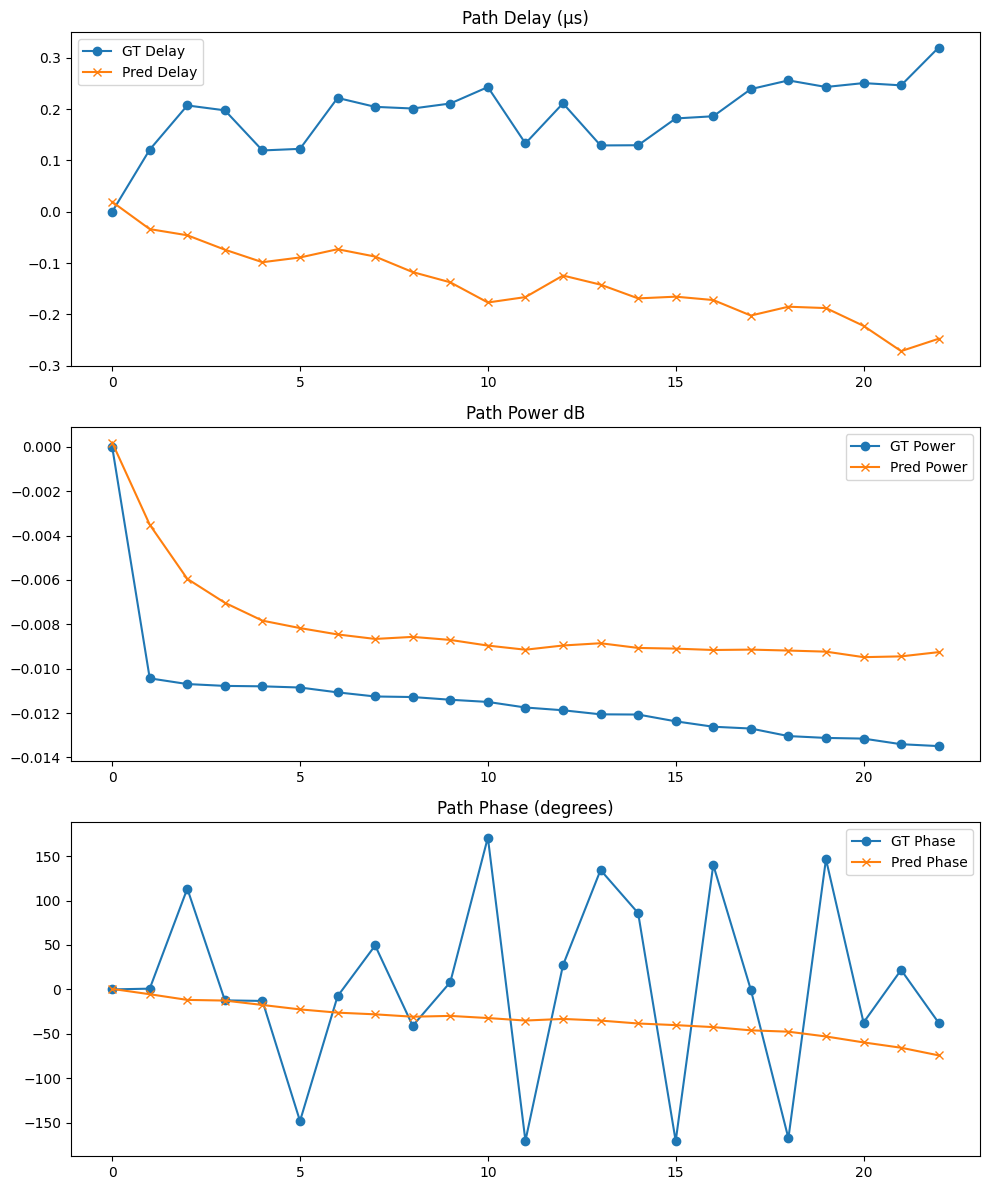

In [51]:
show_example(model, val_loader, sample_index=19)



